# 梯度下降
挑选一个初始值w0,重复迭代参数t=1,2,3
沿着梯度方向将增加损失函数值
学习率:步长的超参数,就是沿着下降方向走多远
寻找一个梯度下降最快的地方,沿着这个梯度最快的方向迭代一次,选择学习率不能太大也不能太小,计算梯度是最贵的那一部分
学习率太大也会有可能迈过最优解
## 小批量随机梯度下降
在整个训练集上算梯度太贵
一个神经网络模型可能需要很长时间
## 选择批量大小
不能太小,也不能太大,太大内存消耗增加,浪费计算
## 总结
梯度下降通过不断沿着反梯度方向更新参数求解,小批量随机梯度下降是深度学习默认的求解算法
两个重要的超参数是批量大小和学习率

# 线性回归从零开始实现


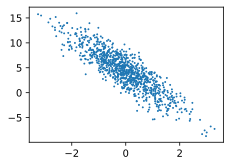

In [3]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1);

In [11]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

def synthetic_data(w,b,num_examples):
    #均值是0,标准差为1的样本
    X=torch.normal(0,1,(num_examples,len(w)))
    #matmul是进行矩阵乘法
    y=torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

true_w = torch.tensor([2,-3.4],dtype=torch.float32)
true_b=4.2
features,labels = synthetic_data(true_w,true_b,1000)

def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    #利用shuffle函数将样本打乱
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]
batch_size=10

for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b
#定义损失函数
def squared_loss(y_hat,y):
    #均方损失
    return (y_hat-y.reshape(y_hat.shape))**2/2

#定义优化算法
def sgd(params,lr,batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()
#训练过程
lr=0.006
num_epochs=8
net=linreg
loss=squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

#跟真实情况的误差
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')
        

tensor([[-1.8095,  0.7340],
        [-0.5498,  0.6219],
        [-0.2089, -0.0380],
        [-0.1849, -0.4539],
        [-1.3319,  0.3921],
        [-1.7460,  0.2668],
        [ 0.1825,  0.3645],
        [-1.6872, -0.2309],
        [-1.0538, -0.7355],
        [ 0.1783,  0.4728]]) 
 tensor([[-1.9149],
        [ 0.9874],
        [ 3.9205],
        [ 5.3869],
        [ 0.2101],
        [-0.1984],
        [ 3.3290],
        [ 1.6073],
        [ 4.5898],
        [ 2.9547]])
epoch1,loss4.988342
epoch2,loss1.536860
epoch3,loss0.473765
epoch4,loss0.146132
epoch5,loss0.045101
epoch6,loss0.013951
epoch7,loss0.004337
epoch8,loss0.001375
w的估计误差：tensor([ 0.0210, -0.0316], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0351], grad_fn=<RsubBackward1>)


In [12]:
#使用框架
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
from torch import nn    
    
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w,true_b,1000) # 库函数生成人工数据集    

# 调用框架现有的API来读取数据
def load_array(data_arrays,batch_size,is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays) # dataset相当于Pytorch的Dataset。一个星号*，表示对list解开入参。      
    return data.DataLoader(dataset,batch_size,shuffle=is_train) # 返回的是从dataset中随机挑选出batch_size个样本出来     

batch_size = 10
data_iter = load_array((features,labels),batch_size) # 返回的数据的迭代器
print(next(iter(data_iter))) # iter(data_iter) 是一个迭代器对象，next是取迭代器里面的元素  

# 使用框架的预定义好的层
# nn是神经网络的缩写
net = nn.Sequential(nn.Linear(2,1))

# 初始化模型参数
net[0].weight.data.normal_(0,0.01) # 使用正态分布替换掉weight变量里面的数据值
net[0].bias.data.fill_(0)  # 偏差bias变量里面的值设置为0
print(net[0])

# 计算均方误差使用的是MSELoss类，也称为平方L2范数
loss = nn.MSELoss()  #L1是算术差，L2是平方差

# 实例化SGD实例
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

# 训练过程代码与从零开始时所做的非常相似
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:  # 从DataLoader里面一次一次把所有数据拿出来
#         print("X:",X)
#         print("y:",y)
        l = loss(net(X),y) # net(X) 为计算出来的线性回归的预测值
        trainer.zero_grad() # 梯度清零
        l.backward()
        trainer.step()  # SGD优化器优化模型
    l = loss(net(features),labels)
    print(f'epoch{epoch+1},loss{l:f}')

[tensor([[ 0.4295, -1.0563],
        [ 0.2442, -0.4033],
        [-0.5798,  0.1209],
        [-0.5466, -0.6158],
        [-0.6985,  1.1932],
        [-0.7681, -0.0514],
        [ 0.5758, -0.3214],
        [-1.7152,  0.2070],
        [ 0.4084,  1.1447],
        [-0.1572, -0.0433]]), tensor([[ 8.6273],
        [ 6.0545],
        [ 2.6287],
        [ 5.1957],
        [-1.2454],
        [ 2.8488],
        [ 6.4488],
        [ 0.0703],
        [ 1.1299],
        [ 4.0439]])]
Linear(in_features=2, out_features=1, bias=True)
epoch1,loss0.000238
epoch2,loss0.000106
epoch3,loss0.000108


### 梯度下降
>梯度就是导数
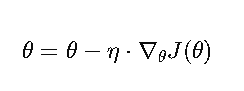


In [3]:
import torch

# 创建一个张量并设置 requires_grad=True 以允许梯度计算
x = torch.tensor(2.0, requires_grad=True)

# 定义一个简单的函数 y = x^2
y = x ** 2

# 反向传播以计算梯度
y.backward()

# x 的梯度将被计算并存储在 x.grad 中
print(x.grad)  # 输出: tensor(4.)


tensor(4.)


#### 交叉熵损失
>交叉熵损失是样本预测概率与真实概率之间的差值
交叉熵损失用于衡量模型预测的概率分布与真实标签的概率分布之间的差异。
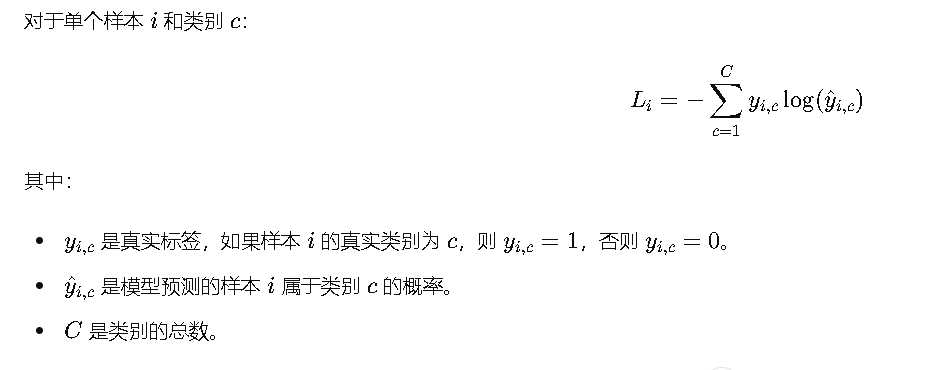

In [4]:
import torch
import torch.nn as nn

# 创建一些示例数据
logits = torch.tensor([[2.0, 0.5, 1.0], [0.5, 2.0, 1.0]], requires_grad=True)  # 模型的原始输出
targets = torch.tensor([0, 1])  # 真实标签

# 定义交叉熵损失函数
loss_fn = nn.CrossEntropyLoss()

# 计算损失
loss = loss_fn(logits, targets)
print(loss)


tensor(0.4644, grad_fn=<NllLossBackward0>)
